# Imports

In [12]:
import os
import shutil
import cv2
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Data Loading Function

In [13]:
def extract_apple_class(source_dir, apple_only_path):
    """
    Extract only apple images from the given directory into a new directory.
    """
    os.makedirs(apple_only_path, exist_ok=True)
    
    all_apples = []
    
    for img_name in os.listdir(source_dir):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            src = os.path.join(source_dir, img_name)
            dst = os.path.join(apple_only_path, img_name)
            shutil.copy(src, dst)
            all_apples.append(dst)
    
    print(f"Extracted {len(all_apples)} apple images")
    return all_apples

# path to Apple folder
SOURCE_DIR = '/kaggle/input/fruit-recognition/Apple/Apple A'
APPLE_ONLY_PATH = '/kaggle/working/apple_images'

# Extracting the apple images
apple_images = extract_apple_class(SOURCE_DIR, APPLE_ONLY_PATH)

# Splitting into train/validation
if len(apple_images) > 0:
    X_train, X_valid = train_test_split(apple_images, test_size=0.2, random_state=42)
    print(f"Training set: {len(X_train)} images")
    print(f"Validation set: {len(X_valid)} images")
else:
    print("No apple images found. Please check your SOURCE_DIR path.")

Extracted 692 apple images
Training set: 553 images
Validation set: 139 images


# Loading the Apple Data

In [14]:
input_size = 64 * 64 * 3
latent_dimension = 128

In [15]:
def load_images(image_paths, target_size=(64, 64)):
    data = []
    for img_path in image_paths:
        img = image.load_img(img_path, target_size=target_size)
        img_array = image.img_to_array(img)
        data.append(img_array)
    return np.array(data)

# Creating the Noise Function

In [16]:
def add_noise(images, noise_factor=0.1):
    # we will be adding Guassian noise to the images.
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = np.clip(noisy_images, 0.0, 1.0)
    return noisy_images

# Reshaping, Normalizing Adding Noise to the Data

In [17]:
X_train_arr = load_images(X_train, target_size=(64, 64))
X_valid_arr = load_images(X_valid, target_size=(64, 64))

X_train_clean = X_train_arr.astype("float32") / 255.0
X_valid_clean = X_valid_arr.astype("float32") / 255.0

# Noisy images as (inputs) 
X_train_noisy = add_noise(X_train_clean, noise_factor=0.2)
X_valid_noisy = add_noise(X_valid_clean, noise_factor=0.2)

# Visualizing Noise levels.

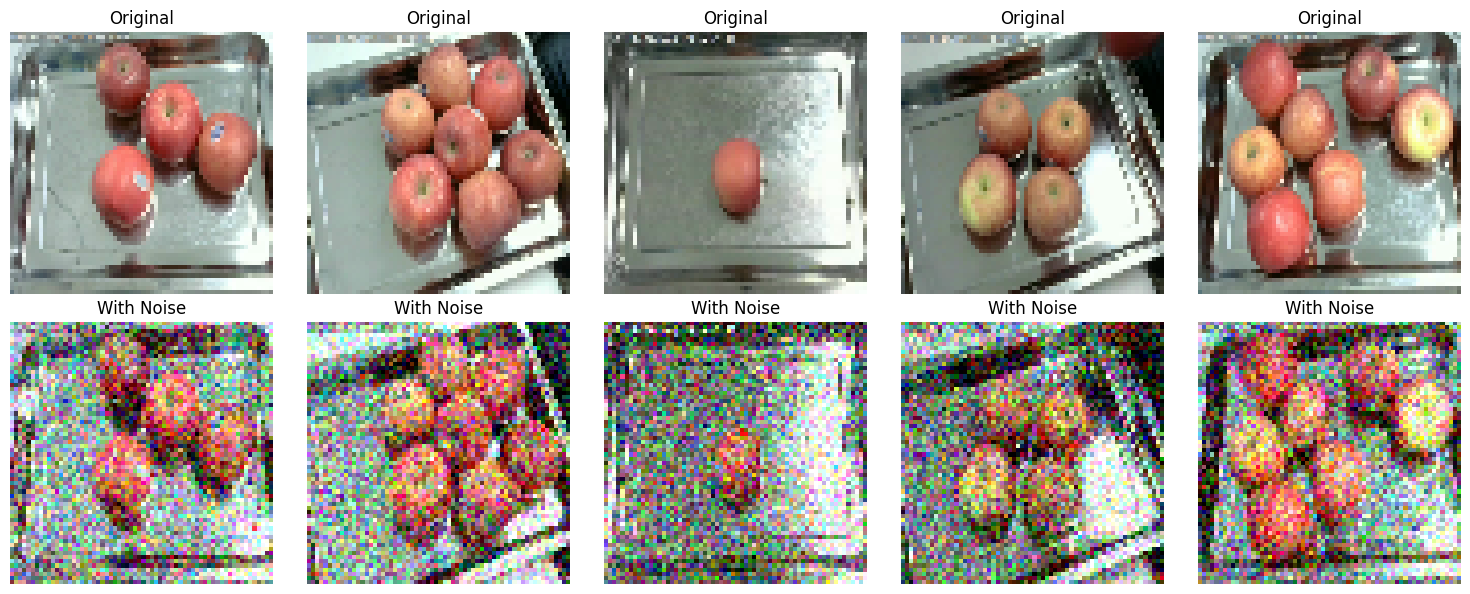

In [18]:
def visualize_noise_levels(clean_images, noisy_images, n_images=5):
    fig, axes = plt.subplots(2, n_images, figsize=(15, 6))
    for i in range(n_images):
        axes[0, i].imshow(clean_images[i])
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')

        axes[1, i].imshow(np.clip(noisy_images[i], 0, 1))
        axes[1, i].set_title('With Noise')
        axes[1, i].axis('off')
    plt.tight_layout()
    plt.show()
    
visualize_noise_levels(X_train_clean, X_train_noisy)

# Building the Autoencoder Architecture

In [19]:
def create_unet_autoencoder(input_shape=(64, 64, 3)):
    """
    U-Net style autoencoder with skip connections for better detail preservation
    """
    inputs = layers.Input(shape=input_shape)
    
    # Encoder (Contracting Path)
    # Block 1
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)  # 32x32
    
    # Block 2
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)  # 16x16
    
    # Block 3
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)  # 8x8
    
    # Bottleneck
    bottleneck = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    bottleneck = layers.BatchNormalization()(bottleneck)
    bottleneck = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(bottleneck)
    bottleneck = layers.BatchNormalization()(bottleneck)
    
    # Decoder (Expanding Path) with Skip Connections
    # Block 4
    up4 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bottleneck)  # 16x16
    up4 = layers.concatenate([up4, conv3])  # Skip connection
    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up4)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    
    # Block 5
    up5 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4)  # 32x32
    up5 = layers.concatenate([up5, conv2])  # Skip connection
    conv5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up5)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = layers.BatchNormalization()(conv5)
    
    # Block 6
    up6 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv5)  # 64x64
    up6 = layers.concatenate([up6, conv1])  # Skip connection
    conv6 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = layers.BatchNormalization()(conv6)
    
    # Output layer
    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(conv6)
    
    return keras.Model(inputs=inputs, outputs=outputs, name='unet_autoencoder')

# Create the model
unet_autoencoder = create_unet_autoencoder()

In [20]:
unet_autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [21]:
unet_autoencoder.summary()

Model: "unet_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 64, 64,    │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 64, 64,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 32, 32,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 16, 16,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 8, 8, 256) │    295,168 │ max_pooling2d_5[

 Total params: 1,931,299 (7.37 MB)

 Trainable params: 1,928,483 (7.36 MB)

 Non-trainable params: 2,816 (11.00 KB)

# Compiling the Autoencoder

In [22]:
history = unet_autoencoder.fit(
    X_train_noisy, X_train_clean,
    epochs=50,
    batch_size=32,
    validation_data=(X_valid_noisy, X_valid_clean),
    verbose=1
)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - loss: 0.0587 - mae: 0.1806 - val_loss: 0.0558 - val_mae: 0.2038
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - loss: 0.0099 - mae: 0.0741 - val_loss: 0.0412 - val_mae: 0.1647
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - loss: 0.0069 - mae: 0.0618 - val_loss: 0.0430 - val_mae: 0.1697
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - loss: 0.0058 - mae: 0.0564 - val_loss: 0.0435 - val_mae: 0.1693
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - loss: 0.0053 - mae: 0.0538 - val_loss: 0.0458 - val_mae: 0.1736
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0049 - mae: 0.0512 - val_loss: 0.0451 - val_mae: 0.1727
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - loss: 0.0045 - mae: 0.0489 - val_loss: 0.0440 - val_mae: 0.1696
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - loss: 0.0046 - mae: 0.0494 - val_loss: 0.0429 - val_mae: 0.1697
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - loss: 0.0041 - mae: 

# Visualizing Training

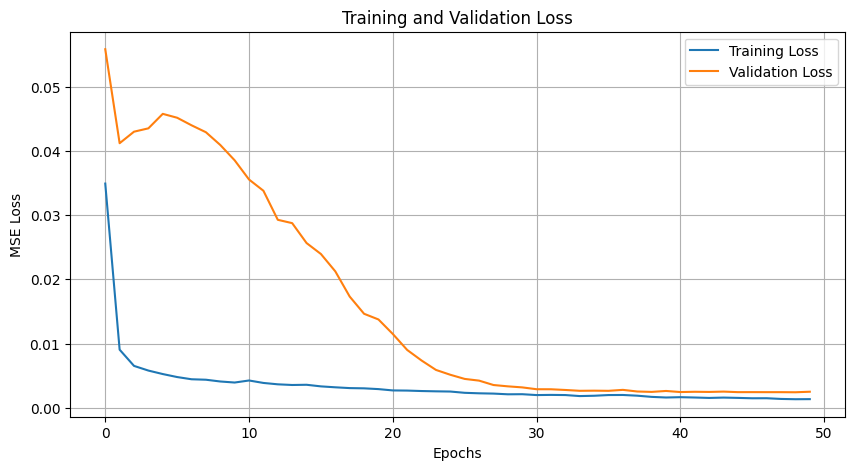

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


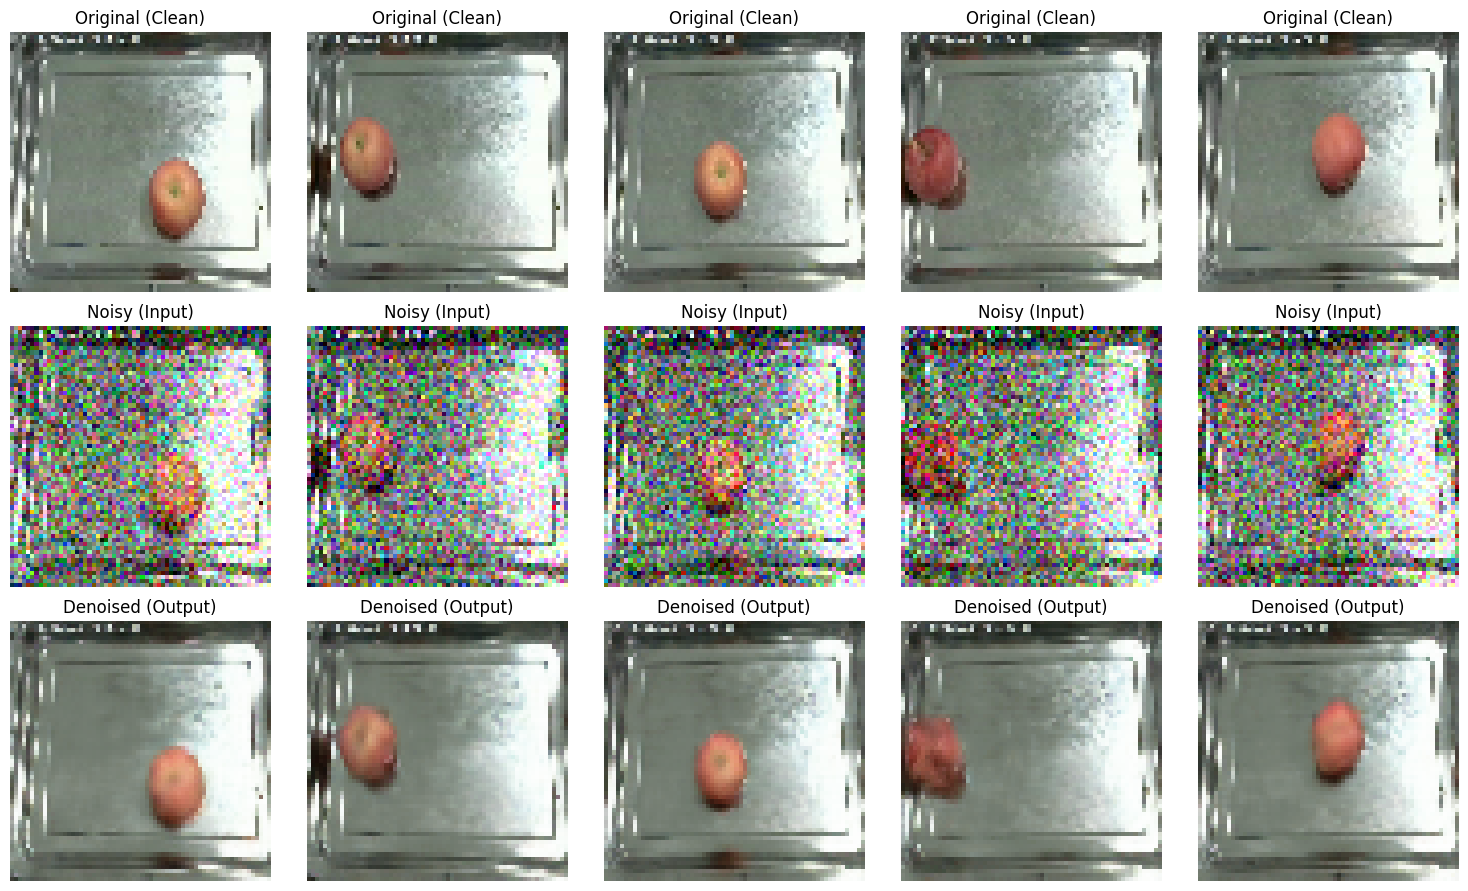

In [25]:
def visualize_denoising(autoencoder, X_valid_clean, X_valid_noisy, n_images=5):
    """
    Visualize original, noisy, and reconstructed images from the autoencoder.
    """
    # Get model predictions (denoised images)
    reconstructed = autoencoder.predict(X_valid_noisy[:n_images])

    fig, axes = plt.subplots(3, n_images, figsize=(15, 9))
    
    for i in range(n_images):
        # Original clean
        axes[0, i].imshow(X_valid_clean[i])
        axes[0, i].set_title('Original (Clean)')
        axes[0, i].axis('off')

        # Noisy input
        axes[1, i].imshow(X_valid_noisy[i])
        axes[1, i].set_title('Noisy (Input)')
        axes[1, i].axis('off')

        # Reconstructed output
        axes[2, i].imshow(np.clip(reconstructed[i], 0, 1))
        axes[2, i].set_title('Denoised (Output)')
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_denoising(unet_autoencoder, X_valid_clean, X_valid_noisy, n_images=5)